### Import des librairies

In [1]:
import pandas as pd
import numpy as np
import IPython.display
import re

# Pour la visualisation graphique :
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import plotly.express as px

# Pour supprimer les warnings :
import warnings
warnings.filterwarnings("ignore")

# pour le modelling des mots :
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import lxml
import html5lib
from bs4 import BeautifulSoup

# Pour la visualisation des tokens :
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

### Fonction pour le nettoyage / visualisation :

In [2]:
# potentiellement à optimisé pour une meilleure visibilité :
def visu_yellow(data):

    # Load the text data
    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(data)
    features = vectorizer.get_feature_names_out()
    visualizer = FreqDistVisualizer(
        features=features, orient='v', size=(1080, 720))
    visualizer.fit(docs)
    visualizer.show()

## Importation des données

Pour les besoins du notebook nous ne conservons que les titres, corps du texte et tags des document importés. 

Nous créons également un chemin pour utiliser nos fichiers dans le drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Stackoverflow/P5_exploration.csv")
data.head()

,Title,Body,Tags
0,Using A Parent Associative Foreach Loop That C...,<p>I have a form that outputs images and their...,<php><foreach><pdo><associative-array>
1,How to remove Header Row from DataFrame Output,<p>When I want to see a df finding the null va...,<python><dataframe>
2,How to run sql script in mysql on Ubuntu?,<p>I am new to sql. I know I can run script wi...,<mysql><sql><script>
3,token verification failing using JWK/JWT for u...,<p>I am trying to verify an idToken using a pu...,<python><oauth-2.0><jwt><rsa><jwk>
4,"Should the ""opening work"" of a context manager...","<p>I found the <a href=""https://book.pythontip...",<python><contextmanager>


# Pré-traitement :

Pour chacune de nos opérations, nous allons utiliser la fonction %%time pour nous permettre de connaître le temps entre chaque opération.

En considérant le temps entre chaque opération, si l'opération est trop longue, il conviendra de faire un pickle pour le garder en mémoire.

### Suppression des balises Tags :

In [5]:
# Preprocess les tags
data["Tags"] = data["Tags"].str.lower() 
data["Tags"] = data["Tags"].replace({"><" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({"<" : ""}, regex=True)
data["Tags"] = data["Tags"].replace({">" : ""}, regex=True)

In [6]:
def clean_tags(text):

    final_string = ""
    pattern = '<>'

    # Remove line breaks
    # Note: that this line can be augmented and used over
    # to replace any characters with nothing or a space
    text = re.sub(pattern, ' ', text)

    # Remove space
    text =text.replace('>', ' ').replace('<', ' ').replace(' '*4, ' ').replace(' '*3, ' ').replace(' '*2, ' ').strip()
    text = text.split()
    final_string = ' '.join(text)

    return final_string

def split_tags(x):
    return x.split()

In [7]:
data["Tags"]=data["Tags"].apply(lambda x : clean_tags(x))
data["Tags"]=data["Tags"].apply(lambda x : split_tags(x))

### Création de la colonne corpus :

Nous commençons par créer une nouvelle variable associant le titre (Title) et le corps du texte (Body)

In [8]:
%%time
data['Corpus'] = data['Title'] + data['Body']
# Certains algorithmes auront besoin d'une liste
corpus = data['Corpus'].to_list()
# Certains algorithmes auront besoin d'une liste
tags = data['Tags'].to_list()
display(data.head(5))

,Title,Body,Tags,Corpus
0,Using A Parent Associative Foreach Loop That C...,<p>I have a form that outputs images and their...,"[php, foreach, pdo, associative-array]",Using A Parent Associative Foreach Loop That C...
1,How to remove Header Row from DataFrame Output,<p>When I want to see a df finding the null va...,"[python, dataframe]",How to remove Header Row from DataFrame Output...
2,How to run sql script in mysql on Ubuntu?,<p>I am new to sql. I know I can run script wi...,"[mysql, sql, script]",How to run sql script in mysql on Ubuntu?<p>I ...
3,token verification failing using JWK/JWT for u...,<p>I am trying to verify an idToken using a pu...,"[python, oauth-2.0, jwt, rsa, jwk]",token verification failing using JWK/JWT for u...
4,"Should the ""opening work"" of a context manager...","<p>I found the <a href=""https://book.pythontip...","[python, contextmanager]","Should the ""opening work"" of a context manager..."


CPU times: user 84.9 ms, sys: 5.45 ms, total: 90.3 ms
Wall time: 91.7 ms


#### Visualisation :

In [9]:
print("Visualisation pré-nettoyage du Corpus :")
print('')
display(data.Corpus[0])
print('')

Visualisation pré-nettoyage du Corpus :



"Using A Parent Associative Foreach Loop That Contains A Glob Function (to delete files) and a PDO Statement To Update A Database - PHP<p>I have a form that outputs images and their related titles and tags via a <code>while</code> loop, and at the bottom of this form I have the option to delete an image.</p>\n<p>Because the input elements inside the form produce an array of values, when deleting an image I need to run the PDO statements and PHP <code>glob</code> methods that delete the images from their folders inside a parent foreach loop.</p>\n<p>I cannot get this to work though. Without the foreach loop I'm getting the PHP <code>Array to string conversion</code> error, which I understand/expect. This error throws on the line <code>$stmt-&gt;bindParam(':image_id', $image_id);</code> in the second section of code below.</p>\n<p>I think I need to wrap the code from in-between the <code>// ---- START FOREACH ?</code> and <code>// ---- END FOREACH ?</code> comments in an associative fore

### Nettoyage HTML via beautiful soup :

Nous allons maintenant nettoyer les données en rapport avec les balises HTML.

In [10]:
%%time

def clean_html(text_html):
    soup = BeautifulSoup(text_html, "html5lib")
    for element in soup.find_all("code"):
        # print(element)
        element.decompose()
    return soup.get_text().replace("\n", " ")


corpus_del_bal = [clean_html(text) for text in corpus]
data['Corpus'] = corpus_del_bal #data['Corpus'].apply(lambda x : clean_html(x))

CPU times: user 3min 36s, sys: 730 ms, total: 3min 36s
Wall time: 3min 45s


#### Visualisation :

In [11]:
print("Visualisation du nettoyage Beautiful Soup :")
print('')
display(corpus_del_bal[0])
print('')

Visualisation du nettoyage Beautiful Soup :



"Using A Parent Associative Foreach Loop That Contains A Glob Function (to delete files) and a PDO Statement To Update A Database - PHPI have a form that outputs images and their related titles and tags via a  loop, and at the bottom of this form I have the option to delete an image. Because the input elements inside the form produce an array of values, when deleting an image I need to run the PDO statements and PHP  methods that delete the images from their folders inside a parent foreach loop. I cannot get this to work though. Without the foreach loop I'm getting the PHP  error, which I understand/expect. This error throws on the line  in the second section of code below. I think I need to wrap the code from in-between the  and  comments in an associative foreach loop, but I can't work how to do this in terms of the key/value pairs? Any help would be really appreciated. Output onto page (the issue is in the block of code after this)  Deleting An Image  "

#### Visualisation Yellowbricks en token :

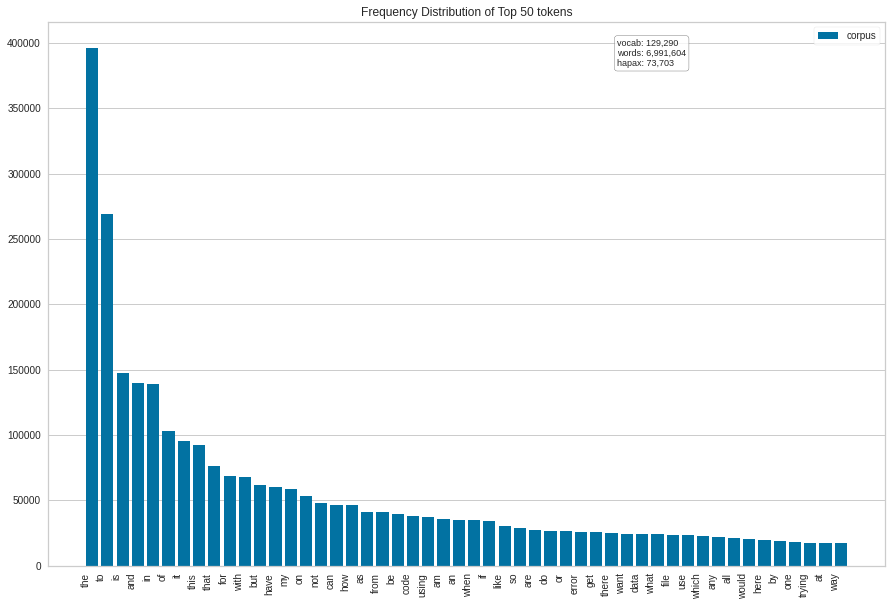

In [12]:
visu_yellow(corpus_del_bal)

On voit qu'il y a toujours des mots redondants qui ne servent à rien à l'analyse.

### Nettoyage du texte (Suppression des fins de lignes et des chiffres) :

ici, nous supprimons les fins de lignes et les chiffres.

In [13]:
%%time

def text_cleaning(text):
    text = re.sub('\w*\d\w*', '', text)  # supprimer tout les chiffres
    text = re.sub(r'\n', '', text)  # retirer les fins de lignes
    text = re.sub(r'\s+', ' ', text)  # retirer les fins de lignes de corpus
    # text = re.split("," , " ")
    return text


corpus_x = [text_cleaning(text) for text in corpus_del_bal]  # pour la liste
#tags_x = [text_cleaning(text).strip() for text in tags]  # pour la liste
data['Corpus'] = data['Corpus'].apply(lambda x : text_cleaning(x))

CPU times: user 14.6 s, sys: 58 ms, total: 14.7 s
Wall time: 14.7 s


In [14]:
tags_x=[]

for tag in tags:
    tags_x.extend(tag)

In [15]:
#tags_x = [text for text in tags]  # pour la liste

#### Visualisation :

#### Visualisation Yellowbricks en token :

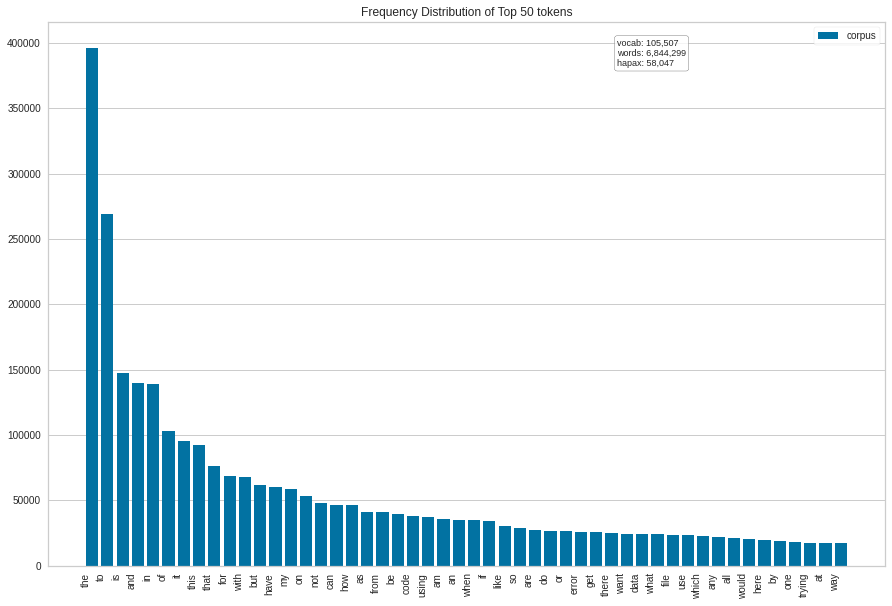

In [16]:
visu_yellow(corpus_x)

Le corpus pré-nettoyé reste actuellement inutilisable.

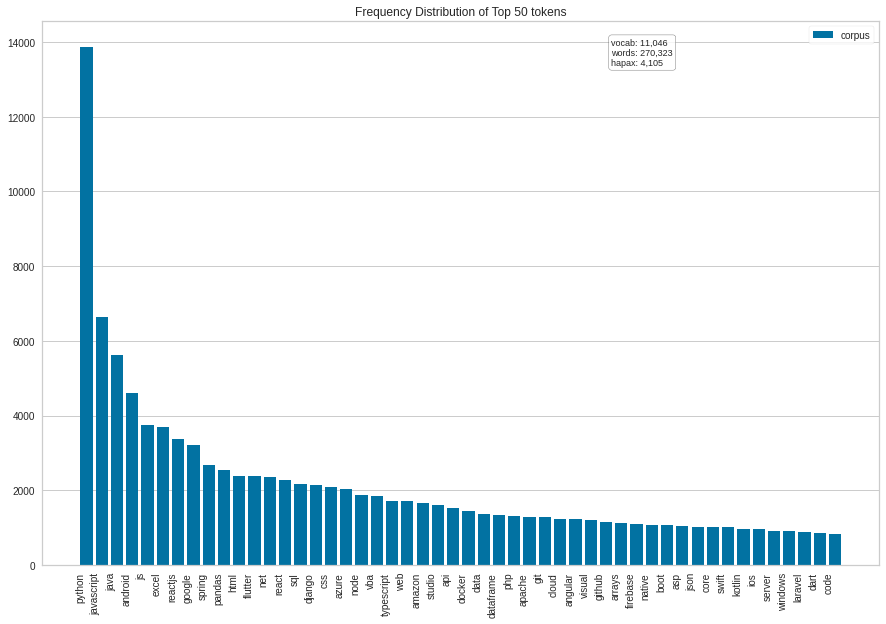

In [17]:
visu_yellow(tags_x)

Ici, on peut voir que les Tags sont bien représentés.

### Suppression des verbes contractées :

Suppression des formes contractés des verbes.

In [18]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [19]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match)\
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [20]:
%%time
corpus_x = [expand_contractions(text) for text in corpus_del_bal]
#tags_x = [expand_contractions(text).strip() for text in tags_x]
# data['Corpus'] = data['Corpus'].apply(lambda x : expand_contractions(x))

CPU times: user 1min 16s, sys: 181 ms, total: 1min 16s
Wall time: 1min 16s


In [21]:
data['Corpus'] = corpus_x

#### Visualisation 

In [22]:
print('-'*60)
print("Visualisation de la suppression des verbes contractés sur le corpus :")
print('-'*60)
display(corpus_x[0])
print("")

print('-'*60)
print("Visualisation de la suppression des verbes contractés sur les tags :")
print('-'*60)
display(data['Tags'][0])
print("")

------------------------------------------------------------
Visualisation de la suppression des verbes contractés sur le corpus :
------------------------------------------------------------


'Using A Parent Associative Foreach Loop That Contains A Glob Function (to delete files) and a PDO Statement To Update A Database - PHPI have a form that outputs images and their related titles and tags via a  loop, and at the bottom of this form I have the option to delete an image. Because the input elements inside the form produce an array of values, when deleting an image I need to run the PDO statements and PHP  methods that delete the images from their folders inside a parent foreach loop. I cannot get this to work though. Without the foreach loop I am getting the PHP  error, which I understand/expect. This error throws on the line  in the second section of code below. I think I need to wrap the code from in-between the  and  comments in an associative foreach loop, but I cannot work how to do this in terms of the key/value pairs? Any help would be really appreciated. Output onto page (the issue is in the block of code after this)  Deleting An Image  '


------------------------------------------------------------
Visualisation de la suppression des verbes contractés sur les tags :
------------------------------------------------------------


['php', 'foreach', 'pdo', 'associative-array']

#### Visualisation Yellowbricks en token :

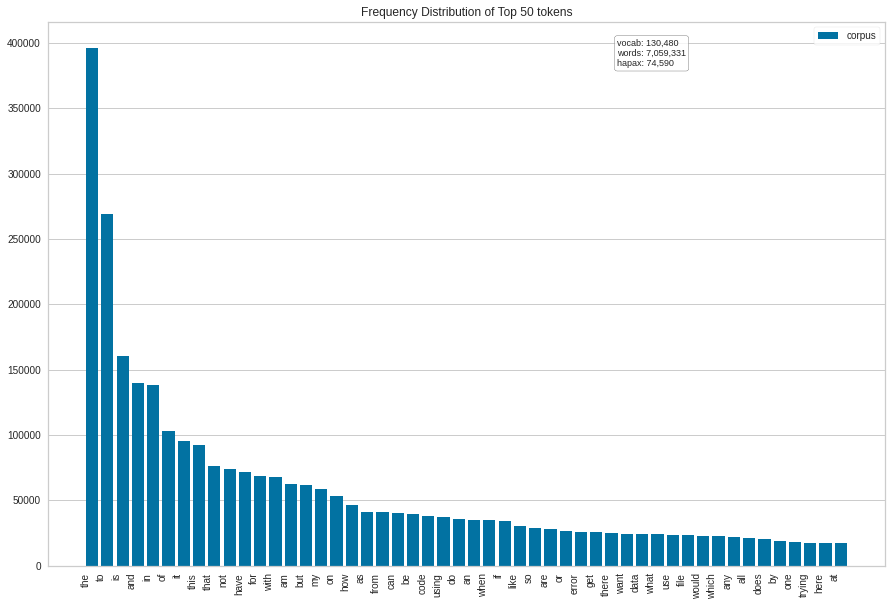

In [23]:
visu_yellow(corpus_x)

Peu de difference ici, vu que les mots contractées ne doivent pas être dans le top 50.

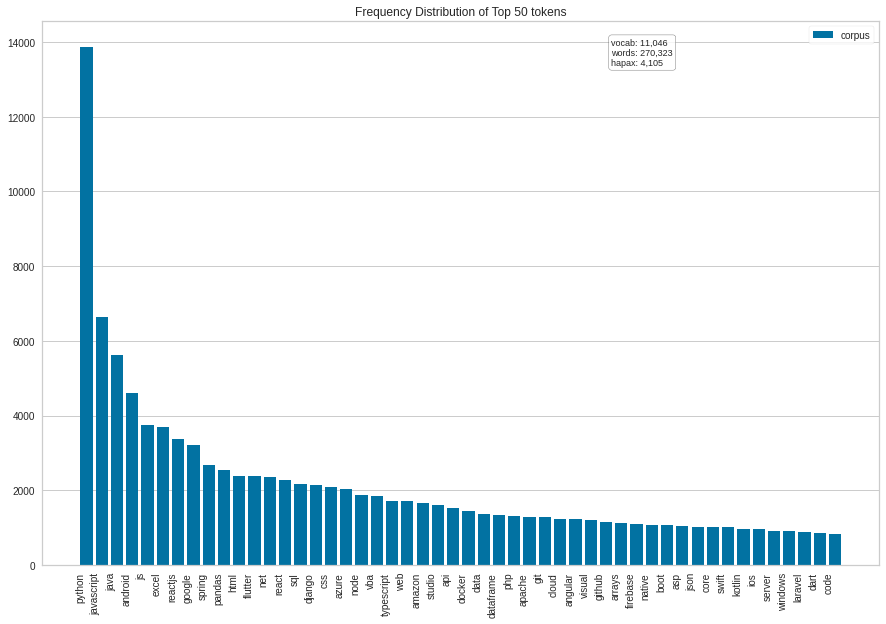

In [24]:
visu_yellow(tags_x)

Idem les tags étant déjà des termes spécifiques, pas de raison de retrouver une difference entre les 2.

### Tokenization + suppression des stopwords :

La tokenisation consiste essentielleent à diviser une phrase, paragraphe ou un document de texte en unités plus petites, entant que mots ou termes individuels. On appelle ces mots des tokens d'ou tokenisation.

Un stopword est un mot qui est tellement commun qu'il est inutile de l'indexer ou de l'utiliser dans une recherche.

In [25]:
import string  # permet d'avoir accés à toute les ponctuations.
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
def tokenize(text):

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    try:
        res = word_tokenize(text, language='english')
    except TypeError:
        return text

    res = [token for token in res if token not in punctuation]
    res = [token for token in res if token not in stop_words]
   # res = [token for token in res if token not in letters]
    return res

In [27]:
%%time
corpus_token = [tokenize(text) for text in corpus_x]
#tag_token = [tokenize(text) for text in tags_x]
# data['Corpus'] = data['Corpus'].apply(lambda x : tokenize(x))

CPU times: user 1min 8s, sys: 2.08 s, total: 1min 11s
Wall time: 1min 11s


#### Visualisation :

In [28]:
print('-'*65)
print("Visualisation de la suppression de la tokennisation sur le corpus :")
print('-'*65)
display(corpus_token[0])
print("")

-----------------------------------------------------------------
Visualisation de la suppression de la tokennisation sur le corpus :
-----------------------------------------------------------------


['Using',
 'A',
 'Parent',
 'Associative',
 'Foreach',
 'Loop',
 'That',
 'Contains',
 'A',
 'Glob',
 'Function',
 'delete',
 'files',
 'PDO',
 'Statement',
 'To',
 'Update',
 'A',
 'Database',
 'PHPI',
 'form',
 'outputs',
 'images',
 'related',
 'titles',
 'tags',
 'via',
 'loop',
 'bottom',
 'form',
 'I',
 'option',
 'delete',
 'image',
 'Because',
 'input',
 'elements',
 'inside',
 'form',
 'produce',
 'array',
 'values',
 'deleting',
 'image',
 'I',
 'need',
 'run',
 'PDO',
 'statements',
 'PHP',
 'methods',
 'delete',
 'images',
 'folders',
 'inside',
 'parent',
 'foreach',
 'loop',
 'I',
 'get',
 'work',
 'though',
 'Without',
 'foreach',
 'loop',
 'I',
 'getting',
 'PHP',
 'error',
 'I',
 'understand/expect',
 'This',
 'error',
 'throws',
 'line',
 'second',
 'section',
 'code',
 'I',
 'think',
 'I',
 'need',
 'wrap',
 'code',
 'in-between',
 'comments',
 'associative',
 'foreach',
 'loop',
 'I',
 'work',
 'terms',
 'key/value',
 'pairs',
 'Any',
 'help',
 'would',
 'really',
 


-----------------------------------------------------------------
Visualisation de la suppression de la tokennisation sur les tags :
-----------------------------------------------------------------


NameError: ignored

###  POS tagging :

Parts of Speech (POS) Tagging. Parts of speech tagging simply refers to assigning parts of speech to individual words in a sentence, which means that, unlike phrase matching, which is performed at the sentence or multi-word level, parts of speech tagging is performed at the token level.

source : https://stackabuse.com/python-for-nlp-parts-of-speech-tagging-and-named-entity-recognition/

NN: noun, common, singular or mass

POS tagging Parts of Speech (POS) Tagging. Parts of speech tagging simply refers to assigning parts of speech to individual words in a sentence, which means that, unlike phrase matching, which is performed at the sentence or multi-word level, parts of speech tagging is performed at the token level.

NN: noun, common, singular or mass

source : https://stackabuse.com/python-for-nlp-parts-of-speech-tagging-and-named-entity-recognition/:

In [29]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [30]:
def filtering_nouns(text):

    res = nltk.pos_tag(text)

    res = [token[0] for token in res if token[1] == 'NN']# Rajouter adverbe etc etc

    return res

In [31]:
%%time
nn_corpus = [filtering_nouns(tokens) for tokens in corpus_token]

CPU times: user 4min 42s, sys: 2.2 s, total: 4min 44s
Wall time: 4min 49s


#### Visualisation :

In [32]:
print('-'*65)
print("Visualisation du POS Tagging sur le corpus :")
print('-'*65)
display(nn_corpus[0])
print("")

-----------------------------------------------------------------
Visualisation du POS Tagging sur le corpus :
-----------------------------------------------------------------


['delete',
 'form',
 'loop',
 'form',
 'option',
 'image',
 'input',
 'form',
 'array',
 'image',
 'parent',
 'foreach',
 'loop',
 'foreach',
 'loop',
 'error',
 'error',
 'line',
 'section',
 'code',
 'code',
 'foreach',
 'loop',
 'help',
 'issue',
 'block',
 'code',
 'Image']

### Lemmatisation

La lemmatisation désigne un traitement lexical apporté à un texte en vue de son classement dans un index ou de son analyse. Ce traitement consiste à appliquer aux occurrences des lexèmes sujets à flexion un codage renvoyant à leur entrée lexicale commune, que l'on désigne sous le terme de lemme.

source : Wikipedia

In [33]:
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [34]:
def lemmatisation(text):

    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()

    res = [lemmatizer.lemmatize(word, wordnet.VERB) for word in text]
    res = [lemmatizer.lemmatize(word, wordnet.ADJ) for word in res]
    res = [lemmatizer.lemmatize(word, wordnet.NOUN) for word in res]
    res = [lemmatizer.lemmatize(word, wordnet.ADV) for word in res]
    return res

In [35]:
%%time
corpus_lem = [lemmatisation(tokens) for tokens in nn_corpus]

CPU times: user 16.2 s, sys: 245 ms, total: 16.4 s
Wall time: 16.5 s


#### Visualisation :

In [36]:
print('-'*65)
print("Visualisation de la lemmatisation sur le corpus :")
print('-'*65)
display(corpus_lem[0])
print("")

-----------------------------------------------------------------
Visualisation de la lemmatisation sur le corpus :
-----------------------------------------------------------------


['delete',
 'form',
 'loop',
 'form',
 'option',
 'image',
 'input',
 'form',
 'array',
 'image',
 'parent',
 'foreach',
 'loop',
 'foreach',
 'loop',
 'error',
 'error',
 'line',
 'section',
 'code',
 'code',
 'foreach',
 'loop',
 'help',
 'issue',
 'block',
 'code',
 'Image']

# Features Engineering :

## Création des colonnes de preprocessing et création d'un nouveau DF :

In [37]:
# remettre sous forme de phrase et non sous forme de liste
corpus_df = [" ".join(text) for text in corpus_lem]
# On crée un dataframe
corpus_df = pd.DataFrame(corpus_df, columns=['corpus_preprocessing'])

In [38]:
corpus_df

,corpus_preprocessing
0,delete form loop form option image input form ...
1,df pd.DataFrame df.isnull df2.set_index df2.in...
2,script mysql sql path way path path
3,verification user authenticationI verify pytho...
4,work context manager example manager file sugg...
...,...
65997,logout error authentication register login reg...
65998,code workingI game problem code function numbe...
65999,function macro definition source file fragment...
66000,way distance arraysI z y1 z1 yN zN b way find ...


In [39]:
tags_df = [" ".join(tags) for tags in tags]
tags_df = pd.DataFrame(tags_df, columns=['tags_preprocessing'])

In [40]:
tags_df

,tags_preprocessing
0,php foreach pdo associative-array
1,python dataframe
2,mysql sql script
3,python oauth-2.0 jwt rsa jwk
4,python contextmanager
...,...
65997,python django postman
65998,python
65999,c gcc macros gdb
66000,python loops euclidean-distance


In [41]:
df_final = pd.concat([corpus_df, tags_df], axis=1)

In [42]:
df_final['corpus_preprocessing'] = df_final['corpus_preprocessing'].apply(
    lambda x: x.split(' '))
df_final['tags_preprocessing'] = df_final['tags_preprocessing'].apply(
    lambda x: x.split(' '))

In [43]:
corpus_final = df_final['corpus_preprocessing'].to_list()
tags_final = df_final['tags_preprocessing'].to_list()
data_corpus_base = data['Corpus'].to_list()

In [44]:
df_visualisation = pd.concat([data['Corpus'],
                              data['Tags'],
                              df_final['corpus_preprocessing'],
                              df_final['tags_preprocessing']],
                             axis=1)

In [45]:
display(df_visualisation.head())
# Ici on voit bien qu'on a nos tags modifiés et non modifiés,.
# on pourra supprimer les balises via regex par la suite pour les tags

,Corpus,Tags,corpus_preprocessing,tags_preprocessing
0,Using A Parent Associative Foreach Loop That C...,"[php, foreach, pdo, associative-array]","[delete, form, loop, form, option, image, inpu...","[php, foreach, pdo, associative-array]"
1,How to remove Header Row from DataFrame Output...,"[python, dataframe]","[df, pd.DataFrame, df.isnull, df2.set_index, d...","[python, dataframe]"
2,How to run sql script in mysql on Ubuntu?I am ...,"[mysql, sql, script]","[script, mysql, sql, path, way, path, path]","[mysql, sql, script]"
3,token verification failing using JWK/JWT for u...,"[python, oauth-2.0, jwt, rsa, jwk]","[verification, user, authenticationI, verify, ...","[python, oauth-2.0, jwt, rsa, jwk]"
4,"Should the ""opening work"" of a context manager...","[python, contextmanager]","[work, context, manager, example, manager, fil...","[python, contextmanager]"


Avant de calculer le bag of Word, le tf idf et le nmf, on va réduire le nombre de tags pour notre analyse.

## Comptage des Tags :

In [46]:
df_visualisation["Tags_count"] = df_visualisation["tags_preprocessing"].apply(lambda x : len(x))
df_visualisation.head()

,Corpus,Tags,corpus_preprocessing,tags_preprocessing,Tags_count
0,Using A Parent Associative Foreach Loop That C...,"[php, foreach, pdo, associative-array]","[delete, form, loop, form, option, image, inpu...","[php, foreach, pdo, associative-array]",4
1,How to remove Header Row from DataFrame Output...,"[python, dataframe]","[df, pd.DataFrame, df.isnull, df2.set_index, d...","[python, dataframe]",2
2,How to run sql script in mysql on Ubuntu?I am ...,"[mysql, sql, script]","[script, mysql, sql, path, way, path, path]","[mysql, sql, script]",3
3,token verification failing using JWK/JWT for u...,"[python, oauth-2.0, jwt, rsa, jwk]","[verification, user, authenticationI, verify, ...","[python, oauth-2.0, jwt, rsa, jwk]",5
4,"Should the ""opening work"" of a context manager...","[python, contextmanager]","[work, context, manager, example, manager, fil...","[python, contextmanager]",2


In [47]:
print( "Le nombre de Tags dans une question est au nombre de : ", '\033[1m'+ str(round(df_visualisation["Tags_count"].mean(),2)) + '\033[0m')

Le nombre de Tags dans une question est au nombre de :  3.19


# Enregistrer le dataframe dans un PICKLE :

In [48]:
pd.to_pickle(df_visualisation, "/content/drive/My Drive/Colab Notebooks/Stackoverflow/p5_visualisation_part_1.pkl")